# Predicting protected feature
Robin Burke, March 16, 2020

The idea here is to predict the protected feature so that if we have segregated predictors, we'll know what instances use which one.

In [100]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

In [72]:
data = pd.read_csv('Data/scoredTrainingData.csv')

cols = data.columns

print (data.shape)

data.head()

(44102, 86)


,UNIQUE_ID,Overall_Rating,Technical_Skills,Teamwork,Customer_Service,Hire_Again,High_Performer,Protected_Group,Biodata_01,Biodata_02,...,average_S4,average_S5,average_S6,average_S7,average_S8,average_S9,average_S10,average_S11,average_S12,average_S13
0,245021089,3.0,3.0,4.0,4.0,4.0,0.0,0.0,2.0,3.0,...,1.50,3.75,4.25,2.0,3.25,1.0,1.0,1.00,1.25,2.25
1,245181465,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,5.0,...,1.00,3.25,3.75,1.0,2.25,1.0,1.0,1.00,1.00,2.25
2,229682665,3.0,3.0,3.0,3.0,4.0,0.0,1.0,2.0,3.0,...,2.50,1.75,4.50,1.0,1.00,1.0,1.0,2.50,1.00,2.00
3,245174982,4.0,4.0,4.0,4.0,5.0,1.0,0.0,2.0,1.0,...,2.00,3.00,3.75,1.0,2.00,1.0,2.0,2.25,1.50,2.25
4,244979030,2.0,2.0,3.0,2.0,3.0,0.0,0.0,3.0,1.0,...,3.25,4.00,5.00,2.0,2.00,1.0,2.5,4.00,1.25,2.00


In [73]:
data = data.drop(cols[1:7], axis=1)
data.dropna(inplace=True)
data.head()

,UNIQUE_ID,Protected_Group,Biodata_01,Biodata_02,Biodata_03,Biodata_04,Biodata_05,Biodata_06,Biodata_07,Biodata_08,...,average_S4,average_S5,average_S6,average_S7,average_S8,average_S9,average_S10,average_S11,average_S12,average_S13
0,245021089,0.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,7.0,...,1.50,3.75,4.25,2.0,3.25,1.0,1.0,1.00,1.25,2.25
1,245181465,1.0,2.0,5.0,5.0,2.0,3.0,1.0,1.0,5.0,...,1.00,3.25,3.75,1.0,2.25,1.0,1.0,1.00,1.00,2.25
2,229682665,1.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,8.0,...,2.50,1.75,4.50,1.0,1.00,1.0,1.0,2.50,1.00,2.00
3,245174982,0.0,2.0,1.0,2.0,7.0,1.0,1.0,2.0,1.0,...,2.00,3.00,3.75,1.0,2.00,1.0,2.0,2.25,1.50,2.25
4,244979030,0.0,3.0,1.0,6.0,6.0,1.0,3.0,2.0,1.0,...,3.25,4.00,5.00,2.0,2.00,1.0,2.5,4.00,1.25,2.00


In [74]:
data = data[data['Protected_Group'].notna()]
data.shape

(37635, 80)

In [78]:
X_data = data.iloc[:, 2:79]
y_data = data.iloc[:,1]

In [75]:
clf = RandomForestClassifier(max_depth=3, class_weight='balanced', random_state=20200314)
scores = cross_val_score(clf, X_data, y_data, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.01)


In [79]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X_data)

In [80]:
clf = LogisticRegressionCV(cv=5, random_state=20200314).fit(X_scaled, y_data)
clf.score(X_scaled, y_data)

0.7184004251361764

In [88]:
from sklearn.compose import ColumnTransformer, make_column_selector

column_trans = ColumnTransformer(
    [('bio_category', preprocessing.OneHotEncoder(dtype='int'), 
      make_column_selector(pattern='Biodata_'))], remainder=preprocessing.MinMaxScaler())
X_trans = column_trans.fit_transform(X_data)

In [89]:
clf = RandomForestClassifier(max_depth=3, class_weight='balanced', random_state=20200314)
scores = cross_val_score(clf, X_trans, y_data, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.02)


In [95]:
clf = KNeighborsClassifier(50, weights='distance')
scores = cross_val_score(clf, X_trans, y_data, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.70 (+/- 0.01)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_data, random_state=20200314)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='distance')

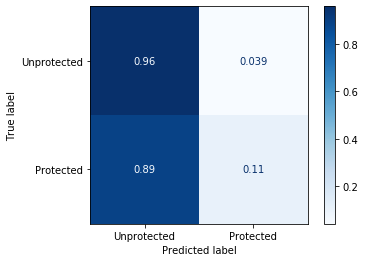

In [98]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Unprotected', 'Protected'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

It is predicting very few protected class labels and getting most of them wrong.

In [101]:
clf = GradientBoostingClassifier(random_state=20200314)
scores = cross_val_score(clf, X_trans, y_data, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.01)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_data, random_state=20200314)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=20200314, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

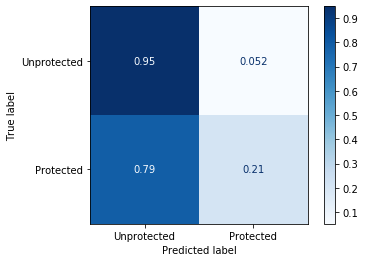

In [103]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Unprotected', 'Protected'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [112]:
X_data_pr = X_data[y_data==1]
X_data_up = X_data[y_data==0].copy()

In [113]:
from sklearn.utils import resample
# Upsample minority class
X_data_sam = resample(X_data_pr, 
                                 replace=True,     
                                 n_samples=len(X_data_up),    
                                 random_state=20200314)

X_data_sam['Protected'] = 1
X_data_up['Protected'] = 0
X_data_sam = X_data_up.append(X_data_sam)
X_data_sam.head()

/Users/robinburke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Biodata_01,Biodata_02,Biodata_03,Biodata_04,Biodata_05,Biodata_06,Biodata_07,Biodata_08,Biodata_09,Biodata_10,...,average_S4,average_S5,average_S6,average_S7,average_S8,average_S9,average_S10,average_S11,average_S12,Protected
0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,7.0,2.0,5.0,...,1.50,3.75,4.25,2.0,3.25,1.0,1.00,1.00,1.25,0
3,2.0,1.0,2.0,7.0,1.0,1.0,2.0,1.0,7.0,1.0,...,2.00,3.00,3.75,1.0,2.00,1.0,2.00,2.25,1.50,0
4,3.0,1.0,6.0,6.0,1.0,3.0,2.0,1.0,1.0,1.0,...,3.25,4.00,5.00,2.0,2.00,1.0,2.50,4.00,1.25,0
6,3.0,3.0,4.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,...,2.25,2.00,4.75,2.0,2.50,2.0,1.50,2.75,1.75,0
8,2.0,5.0,2.0,3.0,1.0,2.0,1.0,1.0,3.0,1.0,...,2.75,2.75,4.75,1.0,2.50,1.0,1.75,4.00,1.25,0


In [114]:
y_samp = X_data_sam.Protected
X_samp = X_data_sam.drop('Protected', axis=1)

In [115]:
clf = GradientBoostingClassifier(random_state=20200314)
scores = cross_val_score(clf, X_samp, y_samp, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.02)


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, random_state=20200314)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=20200314, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

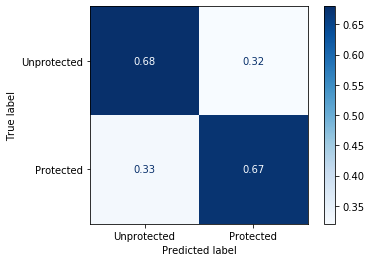

In [118]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Unprotected', 'Protected'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [9]:
clf = RandomForestClassifier(max_depth=2, random_state=20200314)
scores = cross_val_score(clf, bio_sc, bio_df['Protected_Group'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.00)


In [10]:
bio_df.iloc[:,0:20]

,Biodata_01,Biodata_02,Biodata_03,Biodata_04,Biodata_05,Biodata_06,Biodata_07,Biodata_08,Biodata_09,Biodata_10,Biodata_11,Biodata_12,Biodata_13,Biodata_14,Biodata_15,Biodata_16,Biodata_17,Biodata_18,Biodata_19,Biodata_20
0,2,3,2,2,2,1,3,7,2,5,2,2,4,1,2,5,2,1,4,1
1,2,5,5,2,3,1,1,5,2,6,1,1,4,3,2,5,2,4,6,1
2,2,3,1,1,2,2,2,8,5,7,1,2,1,2,2,5,2,5,1,1
3,2,1,2,7,1,1,2,1,7,1,1,2,4,3,2,5,7,7,2,1
4,3,1,6,6,1,3,2,1,1,1,1,2,4,4,3,1,3,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44097,2,1,3,7,1,1,2,1,7,1,1,1,4,2,2,5,7,7,4,1
44098,1,7,5,1,2,1,1,7,4,5,1,1,4,1,1,5,1,6,4,1
44099,1,5,5,5,2,1,1,6,3,3,1,1,4,1,1,5,1,3,7,1
44100,2,7,3,1,1,2,1,7,5,6,1,1,4,2,2,5,1,5,6,1


clf = CatBoostClassifier(iterations=3,
                           depth=3,
                           learning_rate=0.1,
                           loss_function='Logloss',
                         cat_features=range(0, 20),
                           verbose=False)
scores = cross_val_score(clf, bio_df.iloc[:,0:20], bio_df['Protected_Group'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Not any better treating the features as categorical.

## Try with PCA features

In [12]:
pca = PCA(n_components=10)
pca.fit(bio_sc)
pca.explained_variance_ratio_.sum()

0.8266856884500942

In [13]:
bio_xf = pca.transform(bio_sc)

In [14]:
clf = LogisticRegressionCV(cv=5, random_state=20200314).fit(bio_xf, bio_df['Protected_Group'])
clf.score(bio_xf, bio_df['Protected_Group'])

0.6916046288788973

Not any better, but not any worse either.

## Try with additional features
Add time required to answer various questions as another "bio" feature.

In [15]:
bio_time_cols = list(cols[cols.str.contains('Biodata_')]) + \
    list(cols[cols.str.contains('Time_')]) + ['Protected_Group']
bio_time_df = data.loc[:, bio_time_cols].copy()
bio_time_df.dropna(inplace=True)
bio_time_df = bio_time_df.astype('int')

print(bio_time_df.shape)

bio_time_df.head()

(40326, 30)


,Biodata_01,Biodata_02,Biodata_03,Biodata_04,Biodata_05,Biodata_06,Biodata_07,Biodata_08,Biodata_09,Biodata_10,...,SJ_Time_1,SJ_Time_2,SJ_Time_3,SJ_Time_4,SJ_Time_5,SJ_Time_6,SJ_Time_7,SJ_Time_8,SJ_Time_9,Protected_Group
0,2,3,2,2,2,1,3,7,2,5,...,95,101,39,69,65,64,37,64,73,0
1,2,5,5,2,3,1,1,5,2,6,...,53,57,43,53,40,32,39,43,103,1
2,2,3,1,1,2,2,2,8,5,7,...,89,73,90,100,78,66,65,81,70,1
3,2,1,2,7,1,1,2,1,7,1,...,110,86,52,109,103,72,79,59,140,0
4,3,1,6,6,1,3,2,1,1,1,...,35,21,32,81,46,32,31,37,71,0


In [40]:
bio_time_df.describe()

,Biodata_01,Biodata_02,Biodata_03,Biodata_04,Biodata_05,Biodata_06,Biodata_07,Biodata_08,Biodata_09,Biodata_10,...,SJ_Time_1,SJ_Time_2,SJ_Time_3,SJ_Time_4,SJ_Time_5,SJ_Time_6,SJ_Time_7,SJ_Time_8,SJ_Time_9,Protected_Group
count,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,...,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000,40326.000000
mean,2.048356,3.245450,3.809379,3.987551,1.664534,1.964241,1.949834,3.772256,3.779745,3.768016,...,70.948272,66.020929,71.246392,75.451049,52.814140,62.393171,48.033155,61.254451,77.570327,0.308486
std,0.953054,1.718883,1.565956,2.401073,0.676701,1.002148,1.015192,2.719015,2.155227,2.134793,...,93.923107,178.822512,128.624318,101.440347,174.087458,99.743805,73.645228,141.803778,131.221764,0.461874
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,39.000000,35.000000,38.000000,41.000000,28.000000,33.000000,26.000000,34.000000,42.000000,0.000000
50%,2.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,4.000000,3.000000,4.000000,...,55.000000,49.000000,54.000000,58.000000,39.000000,47.000000,36.000000,47.000000,59.000000,0.000000
75%,3.000000,4.000000,5.000000,6.000000,2.000000,3.000000,2.000000,6.000000,6.000000,6.000000,...,80.000000,74.000000,80.000000,85.000000,57.000000,71.000000,53.000000,68.000000,87.000000,1.000000
max,6.000000,8.000000,7.000000,8.000000,5.000000,7.000000,6.000000,8.000000,7.000000,7.000000,...,7373.000000,32158.000000,20964.000000,13321.000000,24873.000000,11257.000000,6338.000000,18361.000000,11938.000000,1.000000


In [51]:
clf = RandomForestClassifier(max_depth=3, class_weight='balanced', 
                             n_estimators=100,
                             random_state=20200314)
scores = cross_val_score(clf, bio_time_df.iloc[:,0:29], bio_time_df['Protected_Group'], cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.629 (+/- 0.016)


Also, not much better

In [17]:
dev = pd.read_csv('Data/DevelopmentData.csv')

dev_cols = dev.columns

print (dev.shape)

dev.head()

(2250, 122)


,UNIQUE_ID,SJ_Most_1,SJ_Least_1,SJ_Time_1,SJ_Most_2,SJ_Least_2,SJ_Time_2,SJ_Most_3,SJ_Least_3,SJ_Time_3,...,PScale12_Q1,PScale12_Q2,PScale12_Q3,PScale12_Q4,PScale13_Q1,PScale13_Q2,PScale13_Q3,PScale13_Q4,PScale13_Q5,split
0,245203329,2.0,4.0,42.0,3.0,2.0,61.0,1.0,3.0,40.0,...,1.0,1.0,4.0,4.0,2.0,1.0,4.0,2.0,3.0,dev
1,245255130,3.0,1.0,117.0,3.0,4.0,89.0,1.0,4.0,79.0,...,3.0,2.0,2.0,3.0,1.0,1.0,4.0,4.0,2.0,dev
2,245127268,3.0,4.0,40.0,1.0,4.0,114.0,1.0,3.0,69.0,...,3.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,dev
3,245117275,2.0,4.0,92.0,3.0,2.0,65.0,1.0,3.0,126.0,...,1.0,1.0,3.0,4.0,1.0,1.0,4.0,3.0,1.0,dev
4,231615474,3.0,1.0,97.0,3.0,4.0,46.0,1.0,4.0,43.0,...,1.0,1.0,4.0,4.0,1.0,1.0,4.0,4.0,1.0,dev


In [44]:
X_train, X_test, y_train, y_test = train_test_split(bio_time_df.iloc[:,0:29], 
                                                    bio_time_df['Protected_Group'], random_state=20200314)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20200314,
                       verbose=0, warm_start=False)

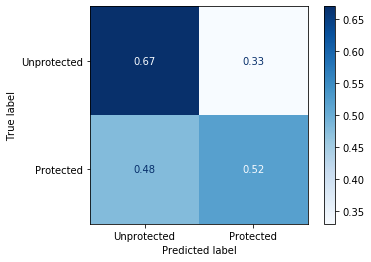

In [48]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Unprotected', 'Protected'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')